In [1]:
import numpy as np
import matplotlib as mt
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MaxNLocator

In [2]:
names1 = ['apo', 'bound', 'allo-apo', 'allo-bound', 'allo-both']
names2 = ['g2489a', 'g249v', 'g249w', 'og249w']

In [3]:
bins = np.arange(0,500,0.5)
xb = bins[1:]-(bins[1]-bins[0])/2
zeros = np.zeros(xb.shape)

In [4]:
def pocket_residues(mdpoc,sort_by_values=True,norm=None,resn=3,resid=5,atom=11,ignore=False,wpol=0.5,wapol=0.35,whyd=0.15,more_pol=[],more_apol=[],more_hyd=[],more_res={}):
    """
    This function operates on MDPOCKET output file containing atom information of the detected pocket over a trajectory:
    This function calculates the consituent amino acid residues of a pocket and their relative contribution.
    #
    ## INPUT ::
    mdpoc - mdpocket output file
    sort_by_values - (bool) if True sort by values, else sort by residue names
    norm - normalization factor 
           None :: no normalisation  :: values depict fraction of amino acid lining the pocket (d)
           int/float  :: normalized by norm :: values depict the normalized
           natom (str) :: special case - to get mean number of atoms a residue is contributing in pocket boundary
                           specially required to figure out which atoms are contributing ::
                           for example :: to understand if OH (tyr) is part of pocket boundary
                                          define OH as polar (only one entry, putting other in apolar) and calculate
                                          i.e., pocket_residues(mdpoc,wpol=1,wapol=0,whyd=0,atom={atom_col},more_pol=['OH'],more_apol=['N','O',S],ignore=True)
    resn - (int) resname col (d - 3)
    resid - (int) resid col (d - 5)
    atom - (int) atom col (d - 11)
    ignore - (bool) False :: do not ignore if unknown atom types are found
                    True  :: ignore unknown atom types {specially for norm='natom'}
    wpol - (float) weight of polar atoms (d - 0.5)    | these factors can be played to detect multiple natures of pocket
    wapo - (float) weight of apolar atoms (d - 0.35)  |    for example :: putting wapol = whyd = 0 :: gives the polar contribution only
    whyd - (float) weight of hydrogen (d - 0.15)      |    
    more_nn - (list) more nn type atoms to be added   | to tuned the polarity of atoms
    more_rr - (dict) more residue types to consider
    #
    ## OUTPUT
             ['residue', contribution]
    #
    """
    #
    import numpy as np
    #
    def resname(name):              # function for extracting residue name only
        if name[:-3].isdigit() == True:
            return name[-3:]
        elif name[:-4].isdigit() == True:
            return name[-4:-1]
        else:
            raise ValueError("Error in user input "+name)
    #
    #
    mean_atoms = { 'GLY':[2,2,3], 'ALA':[2,3,5], 'VAL':[2,5,9], 'LEU':[2,6,11], 'ILE':[2,6,11], 'PRO':[2,5,7], 'MET':[3,4,9], 
                   'THR':[3,4,7], 'SER':[3,3,5], 'CYS':[3,4,7], 'ASN':[4,4,6], 'GLN':[4,5,8], 'ASP':[4,4,5], 'GLU':[4,5,7],
                   'HIS':[4,6,7], 'HSD':[4,6,7], 'HSP':[4,6,8], 'HSE':[4,6,7], 'LYS':[3,5,11], 'ARG':[5,6,12],
                   'TYR':[3,9,9], 'TRP':[3,11,10], 'PHE':[2,9,9]
                  }
    for i in more_res.keys():                # updating residue list upon user input
        mean_atoms[i.upper()] = more_res[i]
    #
    def total_residue_atoms(name,dd=mean_atoms,wp=wpol,wa=wapol,wh=whyd):
        if (name not in dd.keys()):
            raise ValueError("Amino acid not found " + name + "  : UPDATE RESIDUES")
        else:
            return (dd[name][0]*wp + dd[name][1]*wa + dd[name][2]*wh) / (wp+wa+wh)
    #
    #
    polar = ['N','O','S']
    apolar = ['C']
    hydrogens = ['H']
    #
    for i in more_pol:
        polar.append(i)
        if i in apolar:
            apolar = list(np.delete(apolar,apolar.index(i),axis=0))
        elif i in hydrogens:
            hydrogens = list(np.delete(hydrogens,hydrogens.index(i),axis=0))
    for i in more_apol:
        apolar.append(i)
        if i in polar:
            polar = list(np.delete(polar,polar.index(i),axis=0))
        elif i in hydrogens:
            hydrogens = list(np.delete(hydrogens,hydrogens.index(i),axis=0))
    for i in more_hyd:
        hydrogens.append(i)
    #
    #
    p=-1
    data1=[]
    # data1 = [timeframe(model)   {residue :  [polar, apolar, hydrogen      ]        }    ]
    #
    for line in open(mdpoc,'r'):                     # reading mdpocket output file
        items=line.strip().split()
        if items[0] == 'MODEL':                     # looking for model starting
            p=p+1
            data1.append({})                        # adding empty dict for every model
        elif (items[0] == 'ATOM') or (items[0] == 'HETATM'):
            residue = items[resid] + items[resn]
            if (residue not in data1[p].keys()) == True:          # making residue entry in dict
                data1[p][residue] = [0,0,0]
                #
            atype = items[atom]
            if atype in polar:                                  # making atom entry in dictionary
                data1[p][residue][0] = data1[p][residue][0] + 1
            elif atype in apolar:
                data1[p][residue][1] = data1[p][residue][1] + 1
            elif atype in hydrogens:
                data1[p][residue][2] = data1[p][residue][2] + 1
            else:
                if ignore == False:
                    raise ValueError("Unknown atom type detected " + atype + " : UPDATE ATOMS")
            #
    #
    total_atom_numbers = {}                         # counting mean atoms involved in pocket
    total_atom_weight = wpol + wapol + whyd
    total_frames = len(data1)
    for i in range(total_frames):
        for j in data1[i].keys():
            weighted_atoms = (wpol*data1[i][j][0] + wapol*data1[i][j][1] + whyd*data1[i][j][2])/total_atom_weight
            if (j not in total_atom_numbers.keys()) == True:
                total_atom_numbers[j] = weighted_atoms
            else:
                total_atom_numbers[j] = total_atom_numbers[j] + weighted_atoms
    for i in total_atom_numbers.keys():
        total_atom_numbers[i] = total_atom_numbers[i]/total_frames
    #
    mean_residue_contri = {}                       # calculating fraction of  total amino acid
    for i in total_atom_numbers.keys():
        mean_residue_contri[i] = total_atom_numbers[i]/total_residue_atoms(resname(i))
    #
    if sort_by_values == True:         # sorting by values
        mean_residue_contri = sorted(mean_residue_contri.items(), key = lambda kv: (kv[1],kv[0]))[::-1]
    elif sort_by_values == False:
        mean_residue_contri = sorted(mean_residue_contri.items(), key = lambda kv: (kv[0],kv[1]))
    #
    if norm == None:
        finals = np.rec.fromarrays(([i[0] for i in mean_residue_contri],np.array([i[1] for i in mean_residue_contri])), names=('residue','contribution'))
    elif (type(norm) == int) or (type(norm) == float):
        finals = np.rec.fromarrays(([i[0] for i in mean_residue_contri],(np.array([i[1] for i in mean_residue_contri])/np.sum(vals))*norm), names=('residue','contribution'))
    elif norm.upper() == 'NATOM':
        finals = np.rec.fromarrays(([i for i in total_atom_numbers.keys()],[i for i in total_atom_numbers.values()]), names=('residue','contribution'))
    else:
        raise ValueError("Understandable norm " + str(norm))
    #
    return finals

def get_pvol(data, niters=1000, nvals=0.7, remove_zeros=True, verbose=True, rstate=0, replace=True):
    np.random.seed(rstate)
    
    nvals = int(data.shape[0]*nvals)
    
    d = data
    if remove_zeros:
        ind = np.where(data!=0)[0]
        d = data[ind]
        
    means = np.array([ np.mean(np.random.choice(d, size=nvals)) for _ in range(niters) ])
    
    if verbose:
        print(np.round([(data.shape[0]-ind.shape[0])/data.shape[0], np.mean(data), np.mean(means)],2))
        
    return means

### check h atoms contribution

In [5]:
d1=get_pvol(
    np.loadtxt('files_from_pvol/noH_4jx1_apo.txt', dtype=str)[:,1][1:].astype(float)
)
d2=get_pvol(np.loadtxt('files_from_pvol/p450_4jx1_apo.txt')[:,1])

[9.0000e-02 2.1392e+02 2.3541e+02]
[9.0000e-02 2.1401e+02 2.3485e+02]


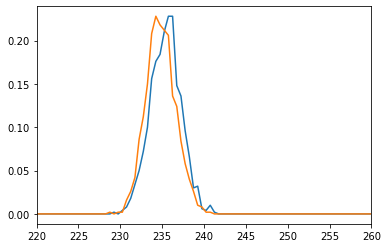

In [6]:
for d in [d1,d2]:
    plt.plot(xb, np.histogram(d, bins=bins, density=True)[0])
plt.xlim(220,260)
plt.show()

In [7]:
d1=get_pvol(np.loadtxt('files_from_pvol/noH_l166a_apo.txt', dtype=str)[:,1][1:].astype(float))
d2=get_pvol(np.loadtxt('files_from_pvol/p450_l166a_apo.txt', dtype=str)[:,1][1:].astype(float))

[ 0.56 36.28 82.48]
[ 0.56 36.23 82.39]


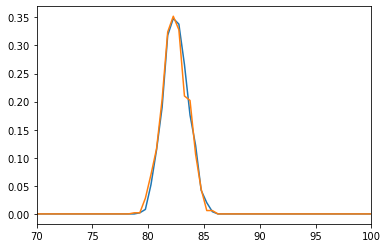

In [8]:
for d in [d1,d2]:
    plt.plot(xb, np.histogram(d, bins=bins, density=True)[0])
plt.xlim(70,100)
plt.show()

In [8]:
wt = [np.loadtxt(f'files_from_pvol/p450_4jx1_{n}.txt', dtype=str)[:,1][1:].astype(float) for n in names1]

In [9]:
mwt=[get_pvol(d) for d in wt]

[9.0000e-02 2.1412e+02 2.3485e+02]
[1.6000e-01 2.0507e+02 2.4335e+02]
[1.2000e-01 2.6874e+02 3.0365e+02]
[5.0000e-02 2.9214e+02 3.0793e+02]
[1.1000e-01 2.6918e+02 3.0397e+02]


In [10]:
hwt = [np.histogram(d, bins=bins, density=True)[0] for d in mwt]

(200.0, 350.0)

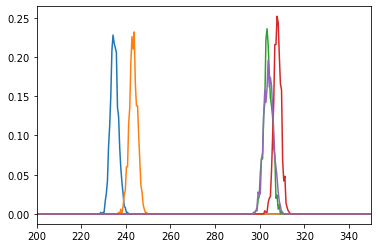

In [12]:
for h in hwt:
    plt.plot(xb,h)
plt.xlim(200,350)

In [11]:
np.mean(mwt, axis=1), np.std(mwt, axis=1)

(array([234.84738111, 243.35038931, 303.64558527, 307.93009848,
        303.97234496]),
 array([1.75982079, 1.84537635, 1.90693846, 1.6228042 , 2.12689333]))

In [5]:
confs = [np.loadtxt(f'files_from_pvol/{n}_p450_4jx1_apo.txt', dtype=str)[:,1][1:].astype(float)
         for n in ['straight', 'kinked']]
mconfs = [get_pvol(d) for d in confs]
hconfs = [np.histogram(d, bins=bins, density=True)[0] for d in mconfs]

[9.0000e-02 2.5366e+02 2.7747e+02]
[9.0000e-02 2.0625e+02 2.2659e+02]


(200.0, 350.0)

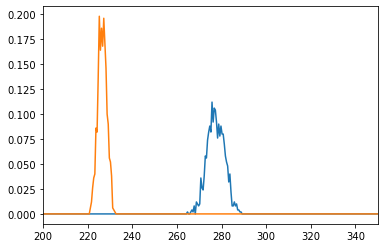

In [6]:
for h in hconfs:
    plt.plot(xb,h)
plt.xlim(200,350)

In [7]:
np.mean(mconfs, axis=1), np.std(mconfs, axis=1)

(array([277.46989305, 226.59222474]), array([3.86563771, 1.99926125]))

In [12]:
mcategories = np.linspace(2.45,3.45,21)
mcategories = mcategories[1:] - (mcategories[1]-mcategories[0])/2
mcategories

array([2.475, 2.525, 2.575, 2.625, 2.675, 2.725, 2.775, 2.825, 2.875,
       2.925, 2.975, 3.025, 3.075, 3.125, 3.175, 3.225, 3.275, 3.325,
       3.375, 3.425])

In [14]:
confs = [np.loadtxt(f'files_from_pvol/conf{i}.txt', dtype=str)[:,1][1:].astype(float) for i in range(20)]
mconfs = [get_pvol(d) for d in confs]
hconfs = [np.histogram(d, bins=bins, density=True)[0] for d in mconfs]

[7.0000e-02 2.7374e+02 2.9397e+02]
[7.0000e-02 2.6863e+02 2.8978e+02]
[8.0000e-02 2.6127e+02 2.8293e+02]
[9.0000e-02 2.4777e+02 2.7171e+02]
[9.0000e-02 2.4751e+02 2.7166e+02]
[1.2000e-01 2.3224e+02 2.6508e+02]
[1.5000e-01 2.1348e+02 2.5128e+02]
[1.4000e-01 1.9446e+02 2.2602e+02]
[1.1000e-01 2.0044e+02 2.2467e+02]
[1.2000e-01 1.9814e+02 2.2486e+02]
[1.0000e-01 2.1003e+02 2.3451e+02]
[8.0000e-02 2.2461e+02 2.4420e+02]
[6.0000e-02 2.3797e+02 2.5402e+02]
[6.0000e-02 2.3320e+02 2.4839e+02]
[7.0000e-02 2.1737e+02 2.3309e+02]
[8.0000e-02 2.1118e+02 2.2843e+02]
[5.0000e-02 2.2091e+02 2.3180e+02]
[3.0000e-02 2.2926e+02 2.3596e+02]
[2.0000e-02 2.2925e+02 2.3345e+02]
[3.0000e-02 2.0526e+02 2.1172e+02]


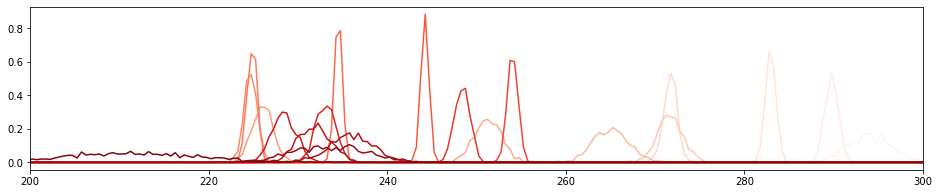

In [20]:
cmap = mt.cm.get_cmap('Reds')
fig,ax=plt.subplots(1,figsize=(16,3))
for a,h in enumerate(hconfs):
    ax.plot(xb, h, color=cmap(a/len(hconfs)))
ax.set_xlim(200,300)
plt.show()

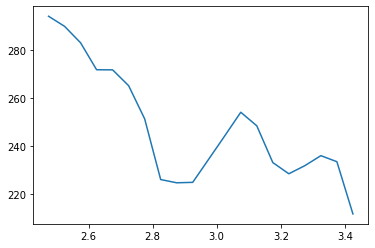

In [22]:
means = [np.mean(h) for h in mconfs]
plt.plot(mcategories, means)

make pocket detection on 100% frames (maybe an effect of small dataset)

In [12]:
closed = [
    np.loadtxt(
    f'files_from_pvol/p450_{n}_apo.txt', dtype=str
    )[:,1][1:].astype(float)
for n in names2]

In [13]:
mclosed = [get_pvol(d) for d in closed]

[  0.26 142.22 192.24]
[  0.32  84.71 124.52]
[  0.26 137.73 185.65]
[  0.39 103.27 169.67]


In [14]:
hclosed=[np.histogram(d, bins=bins, density=True)[0] for d in mclosed]

(100.0, 220.0)

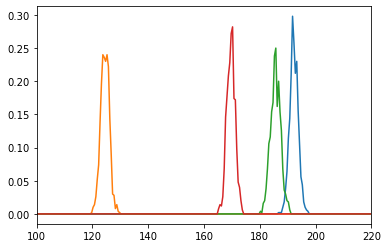

In [31]:
for h in hclosed:
    plt.plot(xb, h)
plt.xlim(100,220)

In [16]:
opened = [np.loadtxt(f'files_from_pvol/p450_l166a_{n}.txt',dtype=str)[:,1][1:].astype(float) for n in names1[:2]]

In [17]:
mopened = [get_pvol(d) for d in opened]

[ 0.56 36.23 82.39]
[6.0000e-02 1.0150e+02 1.0808e+02]


In [18]:
hopened = [np.histogram(d, bins=bins, density=True)[0] for d in mopened]

(50.0, 120.0)

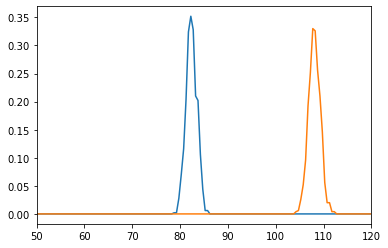

In [35]:
for h in hopened:
    plt.plot(xb,h)
plt.xlim(50,120)

In [20]:
np.mean(mopened, axis=1), np.std(mopened, axis=1)

(array([ 82.38856556, 108.08380896]), array([1.12456828, 1.21796507]))

In [21]:
decoupled = [
    np.loadtxt(
    f'files_from_pvol/p450_f163a_{n}.txt', dtype=str
    )[:,1][1:].astype(float)
for n in names1]

In [22]:
mdecoupled = [get_pvol(d) for d in decoupled]

[1.4000e-01 1.8598e+02 2.1534e+02]
[2.0000e-01 2.0788e+02 2.6121e+02]
[4.0000e-02 3.2136e+02 3.3308e+02]
[8.0000e-02 3.0620e+02 3.3325e+02]
[8.0000e-02 3.2091e+02 3.4714e+02]


In [23]:
hdecoupled=[np.histogram(d, bins=bins, density=True)[0] for d in mdecoupled]

(200.0, 360.0)

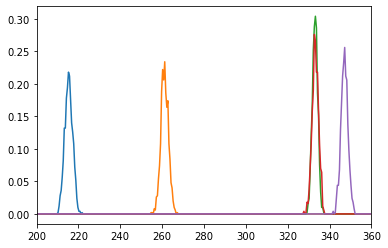

In [39]:
for h in hdecoupled:
    plt.plot(xb,h)
plt.xlim(200,360)

In [25]:
np.mean(mdecoupled, axis=1), np.std(mdecoupled, axis=1)

(array([215.34397625, 261.21213368, 333.07869343, 333.246542  ,
        347.14367961]),
 array([1.88158362, 1.80497141, 1.28595525, 1.55048398, 1.66175827]))

In [40]:
pocket_residues('../1_p450_4jx1_apo/allo-pocket/mdpout_mdpocket_atoms.pdb', resn=3, resid=5, atom=11)

rec.array([('217THR', 0.96202532), ('127LEU', 0.82105263),
           ('123VAL', 0.73170732), ('218ASP', 0.72289157),
           ('168GLY', 0.60465116), ('166LEU', 0.52631579),
           ('126LYS', 0.51020408), ('165LEU', 0.38947368),
           ('219ALA', 0.23214286), ('130ARG', 0.203125  ),
           ('167ALA', 0.17857143)],
          dtype=[('residue', '<U6'), ('contribution', '<f8')])

In [40]:
d1=np.loadtxt('files_from_pvol/p450_4jx1_apo.txt')[:,1]

In [47]:
ith = np.loadtxt('../7_ith_kink/1_ith_318beta_distance/pairdist_ith_318b_p450_4jx1_apo.xvg', 
                comments=['@','#'])[:,1][::100]

In [49]:
h = np.loadtxt('../7_ith_kink/3_ith_and_e_h_movements/2_h_318b/dist_318b_h_p450_4jx1_apo.xvg',
              comments=['@','#'])[:,1][::100]

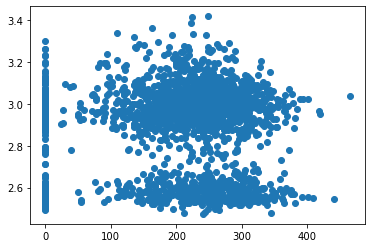

In [51]:
plt.scatter(d1, ith)

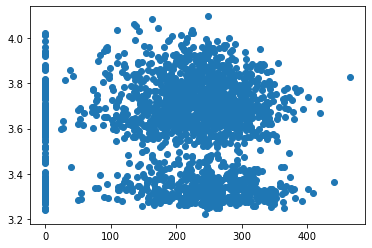

In [52]:
plt.scatter(d1, h)

# e-i Pocket

In [55]:
ei = np.loadtxt('files_from_pvol/ei_4jx1_apo.txt')[:,1]

In [57]:
mei = get_pvol(ei)

[3.0000e-02 2.0460e+02 2.1063e+02]


In [62]:
hei = np.histogram(mei, bins=bins, density=True)[0]

(190.0, 230.0)

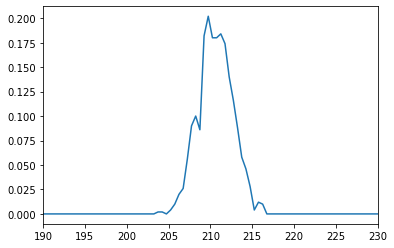

In [65]:
plt.plot(xb, hei)
plt.xlim(190,230)

In [7]:
colors1=['crimson', 'olive', 'green', 'royalblue', 'orange']
colors2=['dodgerblue', 'crimson']

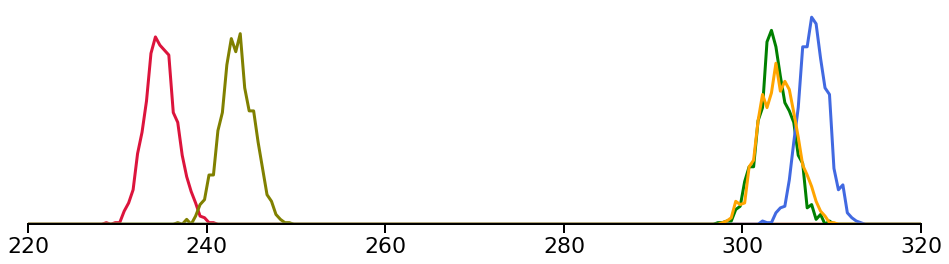

In [23]:
curve = hwt
oname='pvol_wt'

fig,ax=plt.subplots(1, figsize=(16,4))
for a,c in enumerate(curve):
    ax.plot(xb, c, lw=3, color=colors1[a])
ax.set_xlim(220,320)
ax.set_ylim(0,)
ax.spines[['top','left','right']].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelleft=False, left=False, labelbottom=True, length=9, width=2, labelsize=30)
# #
plt.savefig(f'saved_plots/{oname}.pdf', transparent=True)
plt.show()

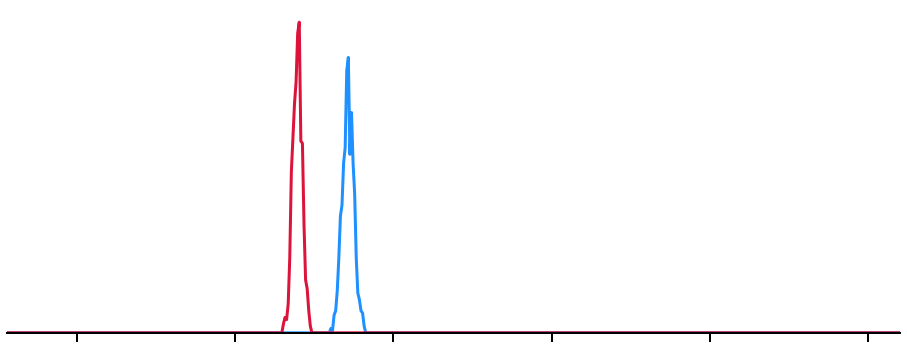

In [42]:
curve = hclosed[2:]
oname='pvol_g249w'

fig,ax=plt.subplots(1, figsize=(16,6))
for a,c in enumerate(curve):
    ax.plot(xb, c, lw=3, color=colors2[a])
ax.set_xlim(78,360)
ax.set_ylim(0,)
ax.spines[['top','left','right']].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelleft=False, left=False, labelbottom=False, length=9, width=2)
# #
plt.savefig(f'saved_plots/{oname}.pdf', transparent=True)
plt.show()

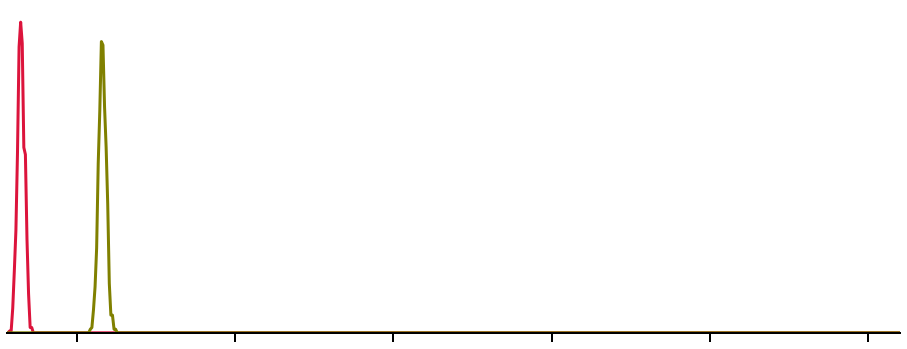

In [44]:
curve = hopened
oname='pvol_l166a'

fig,ax=plt.subplots(1, figsize=(16,6))
for a,c in enumerate(curve):
    ax.plot(xb, c, lw=3, color=colors1[a])
ax.set_xlim(78,360)
ax.set_ylim(0,)
ax.spines[['top','left','right']].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelleft=False, left=False, labelbottom=False, length=9, width=2)
# #
plt.savefig(f'saved_plots/{oname}.pdf', transparent=True)
plt.show()

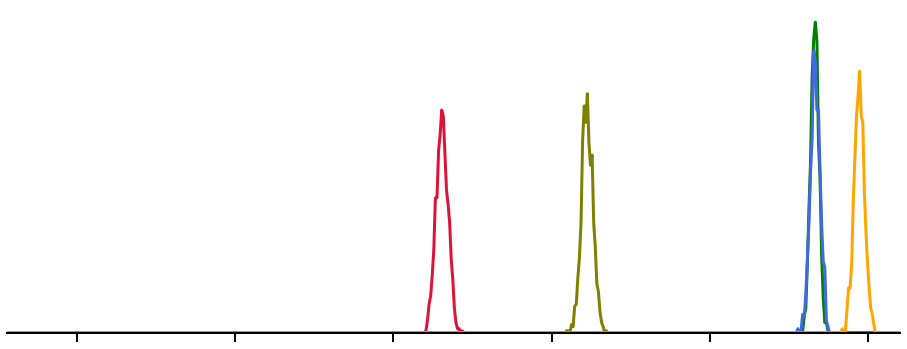

In [45]:
curve = hdecoupled
oname='pvol_f163a'

fig,ax=plt.subplots(1, figsize=(16,6))
for a,c in enumerate(curve):
    ax.plot(xb, c, lw=3, color=colors1[a])
ax.set_xlim(78,360)
ax.set_ylim(0,)
ax.spines[['top','left','right']].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelleft=False, left=False, labelbottom=False, length=9, width=2)
# #
plt.savefig(f'saved_plots/{oname}.pdf', transparent=True)
plt.show()

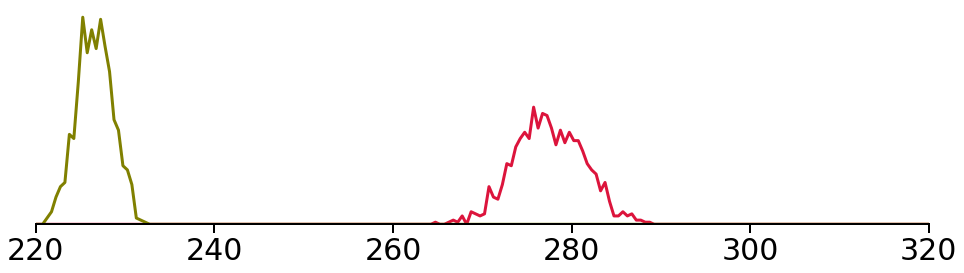

In [9]:
curve = hconfs
oname='pvol_confs'

fig,ax=plt.subplots(1, figsize=(16,4))
for a,c in enumerate(curve):
    ax.plot(xb, c, lw=3, color=colors1[a])
ax.set_xlim(220,320)
ax.set_ylim(0,)
ax.spines[['top','left','right']].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelleft=False, left=False, labelbottom=True, length=9, width=2, labelsize=30)
# #
plt.savefig(f'saved_plots/{oname}.pdf', transparent=True)
plt.show()

In [115]:
0.5 + 0.15 * (0.5/0.85)

0.5882352941176471

In [116]:
0.35 + 0.15 * (0.35/0.85)

0.4117647058823529

## pocket residues

In [56]:
rwt = pocket_residues('files_from_pvol/p450_4jx1_apo.pdb', resn=3, resid=5, atom=11)

In [118]:
rclosed = pocket_residues('files_from_pvol/p450_g249w_apo.pdb', resn=3, resid=4, atom=10,
                         wpol=0.59, wapol=0.41, whyd=0)

In [58]:
ropened = pocket_residues('files_from_pvol/p450_l166a_apo.pdb', resn=3, resid=4, atom=10)

In [120]:
rdecoupled = pocket_residues('files_from_pvol/p450_f163a_apo.pdb', resn=3, resid=4, atom=10,
                            wpol=0.59, wapol=0.41, whyd=0)

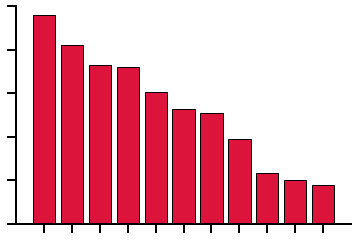

In [121]:
curve = rwt
oname='pres_wt'
fig,ax=plt.subplots(1, figsize=(6,4))
ax.bar(curve['residue'], curve['contribution'], color='crimson', edgecolor='black')
ax.set_xlim(-1,11)
ax.set_ylim(0,1)
ax.spines[['top','right']].set_visible(False)
ax.spines[['left','bottom']].set_linewidth(2)
ax.tick_params(labelleft=False, left=True, labelbottom=False, length=9, width=2)
#
plt.savefig(f'saved_plots/{oname}.pdf', transparent=True)
plt.show()

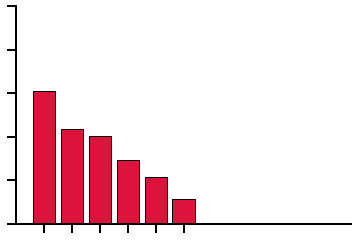

In [122]:
curve = rclosed
oname='pres_g249w'
fig,ax=plt.subplots(1, figsize=(6,4))
ax.bar(curve['residue'], curve['contribution'], color='crimson', edgecolor='black')
ax.set_xlim(-1,11)
ax.set_ylim(0,1)
ax.spines[['top','right']].set_visible(False)
ax.spines[['left','bottom']].set_linewidth(2)
ax.tick_params(labelleft=False, left=True, labelbottom=False, length=9, width=2)
#
plt.savefig(f'saved_plots/{oname}.pdf', transparent=True)
plt.show()

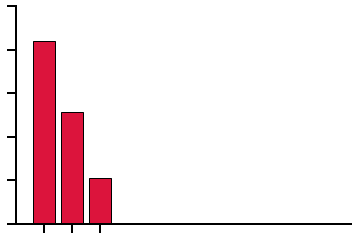

In [100]:
curve = ropened
oname='pres_l166a'
fig,ax=plt.subplots(1, figsize=(6,4))
ax.bar(curve['residue'], curve['contribution'], color='crimson', edgecolor='black')
ax.set_xlim(-1,11)
ax.set_ylim(0,1)
ax.spines[['top','right']].set_visible(False)
ax.spines[['left','bottom']].set_linewidth(2)
ax.tick_params(labelleft=False, left=True, labelbottom=False, length=9, width=2)
#
plt.savefig(f'saved_plots/{oname}.pdf', transparent=True)
plt.show()

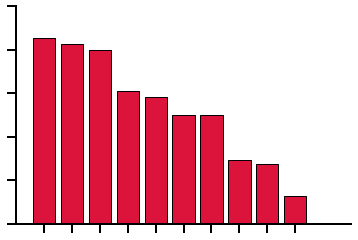

In [123]:
curve = rdecoupled
oname='pres_f163a'
fig,ax=plt.subplots(1, figsize=(6,4))
ax.bar(curve['residue'], curve['contribution'], color='crimson', edgecolor='black')
ax.set_xlim(-1,11)
ax.set_ylim(0,1)
ax.spines[['top','right']].set_visible(False)
ax.spines[['left','bottom']].set_linewidth(2)
ax.tick_params(labelleft=False, left=True, labelbottom=False, length=9, width=2)
#
plt.savefig(f'saved_plots/{oname}.pdf', transparent=True)
plt.show()

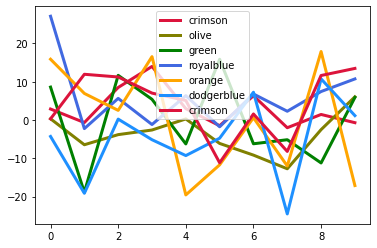

In [25]:
for a,i in enumerate(colors1+colors2):
    plt.plot(np.random.normal(0,10,10), lw=3, color=i, label=i)
plt.legend()
plt.savefig('saved_plots/pvol_labels.pdf')
plt.show()